# Ensemble Learning Project on the moon/mnist datasets

Ensemble Learning is combining different classifiers/regressors to work together, rather than individually.


In [5]:
import numpy as np
import matplotlib.pyplot as plt

## Generate Data

In [239]:
from sklearn.model_selection import train_test_split #used to split training and testing homogenously
from sklearn.datasets import make_moons

X, y =make_moons(n_samples=10000,noise=0.4, random_state=42)
X_train,X_test,y_train, y_test=train_test_split(X,y, random_state=42)

In [240]:
X_train.shape #0.75 of the data

(7500, 2)

In [241]:
X_train[0], y_train[0]

(array([ 0.13454082, -0.06983736]), 1)

Text(0.5, 1.0, 'Make_moons_data')

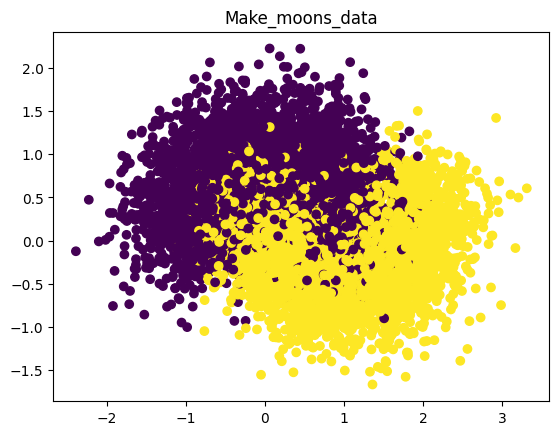

In [242]:
#visualise the data (1 is yellow, 0 is magenta)
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.title("Make_moons_data")

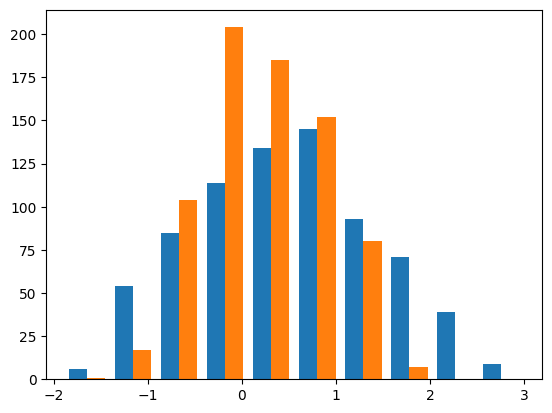

In [147]:
#frequency of each point
plt.hist(X_train, bins=10);

## Voting Classifier-Hard Voting

the data is cleaned, now we just have to train the models. 

In [267]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf=LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf=RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf=SVC(gamma="scale", random_state=42)

voting_clf=VotingClassifier(estimators=[("lr",log_clf),("random",rnd_clf),("svm",svm_clf)],voting="hard")
voting_clf.fit(X_train,y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('random',
                              RandomForestClassifier(random_state=42)),
                             ('svm', SVC(random_state=42))])

In [268]:
from sklearn.metrics import accuracy_score,recall_score, precision_score, confusion_matrix, roc_curve, auc
y_pred=voting_clf.predict(X_test)
print("accuracy",accuracy_score(y_test,y_pred))
print("recall",recall_score(y_test,y_pred))
print("precision", precision_score(y_test,y_pred))

confusion_matrix(y_test,y_pred)

accuracy 0.86
recall 0.8721498371335505
precision 0.8473101265822784


array([[1079,  193],
       [ 157, 1071]], dtype=int64)

### ROC for the Ensemble & the models on their own

In [407]:
###plot ROC
def ROC(clf, name=""):
    y_predict=clf.predict(X_test)
    fpr, tpr, theresholds=roc_curve(y_test,y_predict)
    plt.plot(fpr, tpr, label=clf.__class__.__name__+" "+ str(round(auc(fpr,tpr),4)))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend()

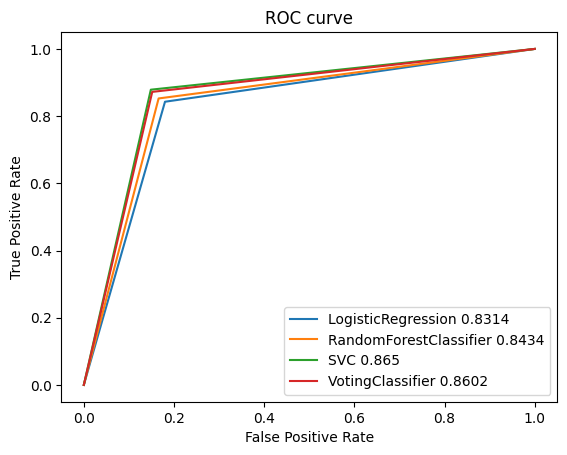

In [270]:
for clf in [log_clf,rnd_clf,svm_clf,voting_clf]:
    clf.fit(X_train,y_train)
    ROC(clf)

## Soft Voting

In [247]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42) #SVC will use cross-validation to ouput probabilities 

voting_1_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

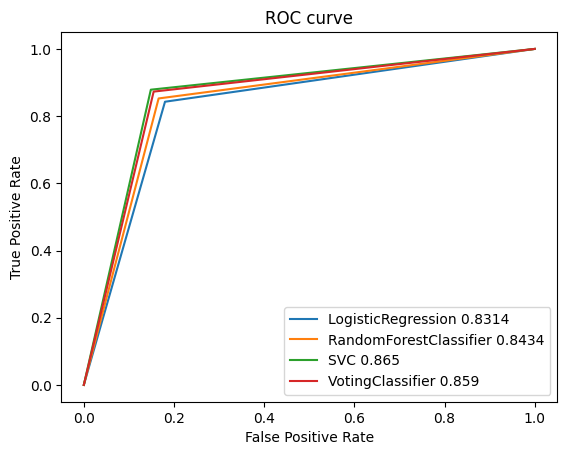

In [248]:
for clf in [log_clf,rnd_clf,svm_clf,voting_1_clf]:
    clf.fit(X_train,y_train)
    ROC(clf)

### Outcome for the Voting Classifier: 
Ensemble IS ALWAYS BETTER. And the soft voting is also better (mainly because we have more degrees of freedom, since we average the probability of the outcome of all classifiers, and not the result!)

## Bagging vs Pasting
Technique is based on the idea: (before different algos), now different parts of the training set! (with replacement- bagging, without replacement - pasting)

In [249]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier 

bag_clf=BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, #500 Treesm
    max_samples=100, bootstrap=True, #with replacement
    oob_score=True,
    n_jobs=-1 #CPU ,
)
#max_samples: int or float, default=1.0
#The number of samples to draw from X to train each base estimator (with replacement by default, see bootstrap for more details).

In [225]:
bag_clf.oob_score_

0.852

In [226]:
accuracy_score(bag_clf.predict(X_test),y_test)

0.864

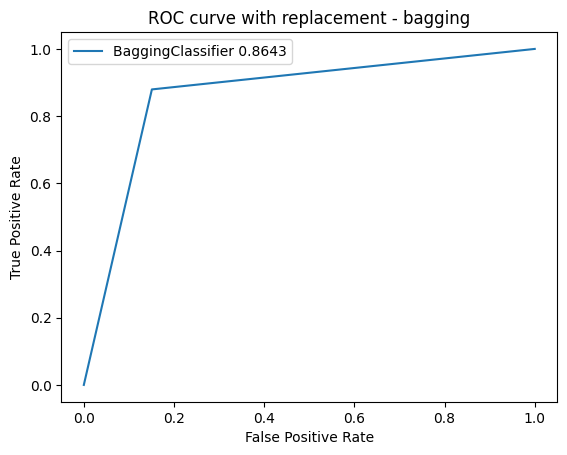

In [250]:
bag_clf.fit(X_train,y_train)
ROC(bag_clf, " with replacement - bagging")

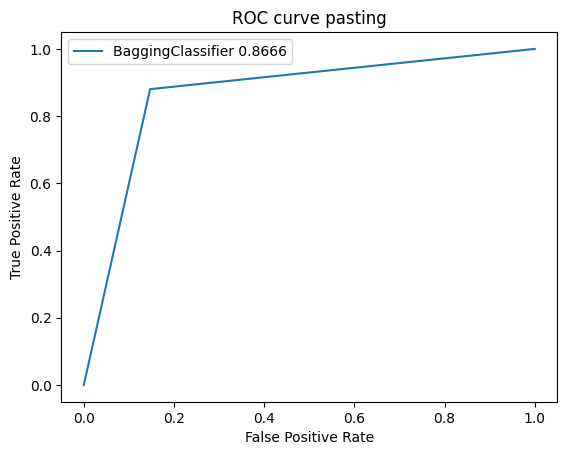

In [251]:
past_clf=BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, #500 Treesm
    max_samples=100, bootstrap=False, #with replacement
    n_jobs=-1 #CPU 
)
past_clf.fit(X_train,y_train)
ROC(past_clf," pasting")

### comparing decision boundaries of Bagging and Pasting

In [256]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=0.01)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=0.01)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

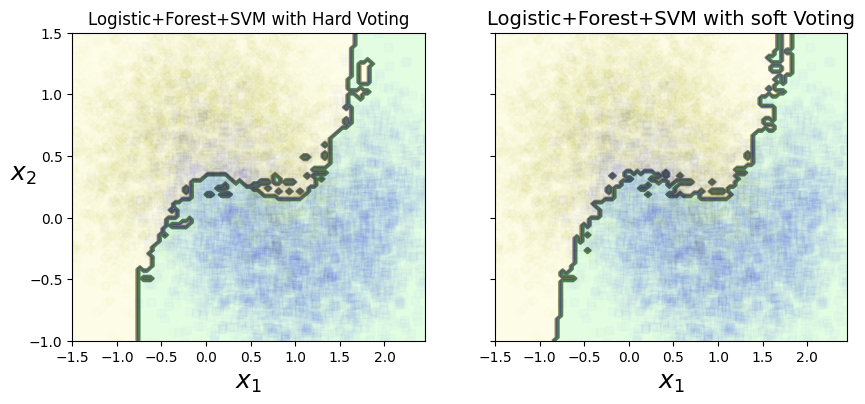

In [257]:
####just to check the boundary between the hard vs soft voting:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(voting_clf,X,y)
plt.title("Logistic+Forest+SVM with Hard Voting")
plt.sca(axes[1])
plot_decision_boundary(voting_1_clf, X, y)
plt.title("Logistic+Forest+SVM with soft Voting", fontsize=14)
plt.ylabel("")
plt.show()

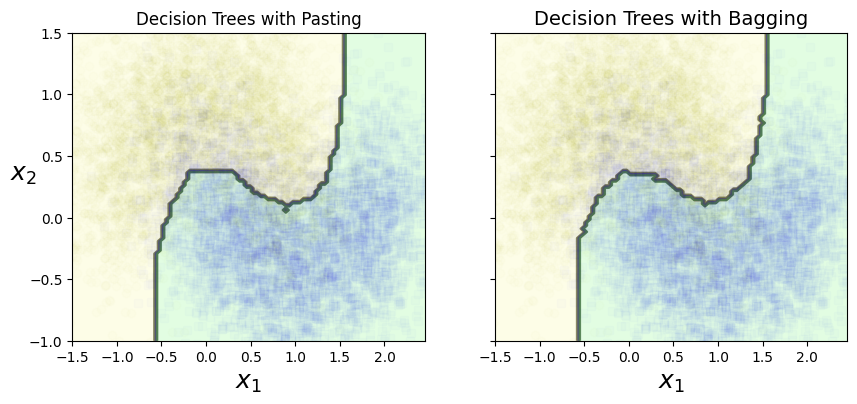

In [258]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(past_clf,X,y)
plt.title("Decision Trees with Pasting")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

### Outcome: 
Bagging is better than pasting in this case. Mainly because the dataset is pretty small.
Tried 100000 instances: Pasting ($0.8625$ AUC), bagging ($0.8619$ AUC). So, it catches up. 

also from the DC boundaries: in bagging there is a little more bias

## Random Forest Classifier

In [310]:
from sklearn.ensemble import RandomForestClassifier

rand_clf=RandomForestClassifier(n_estimators=100,n_jobs=-1)
rand_clf.fit(X_train,y_train)
y_pred_rf=rand_clf.predict(X_test)

In [311]:
##evaluating
print("accuracy",accuracy_score(y_test,y_pred_rf))
print("recall",recall_score(y_test,y_pred_rf))
print("precision", precision_score(y_test,y_pred_rf))
confusion_matrix(y_test,y_pred_rf)

accuracy 0.8484
recall 0.8591205211726385
precision 0.8366375892149088


array([[1066,  206],
       [ 173, 1055]], dtype=int64)

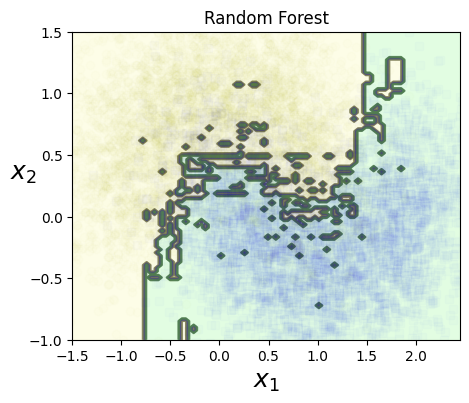

In [312]:
fig, axes = plt.subplots(ncols=1, figsize=(5,4), sharey=True)
plot_decision_boundary(rand_clf,X,y)
plt.title("Random Forest")

plt.show()

In [303]:
####number of trees against accuracy
accuracy=[]
for n in [1,2,3, 10,100,200,500,1000,2000]:
    rand_clf=RandomForestClassifier(n_estimators=n,n_jobs=-1)
    rand_clf.fit(X_train,y_train)
    accuracy.append(accuracy_score(y_test,rand_clf.predict(X_test)))


Text(0, 0.5, 'Accuracy')

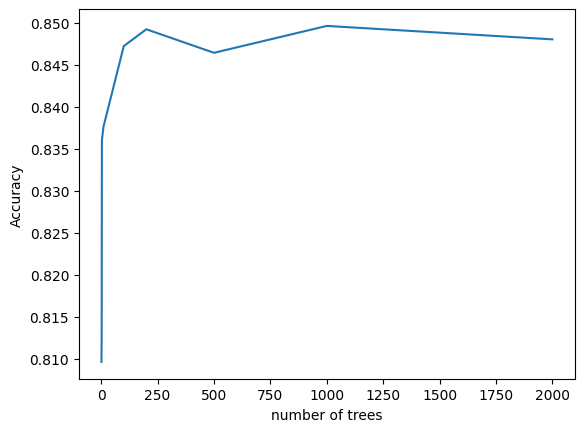

In [313]:
n=np.array([1,2,3,10,100,200,500,1000,2000])
plt.plot(n,accuracy);
plt.xlabel("number of trees")
plt.ylabel("Accuracy")

In [307]:
rand_clf.feature_importances_

array([0.46835066, 0.53164934])

## Boosting.

### AdaBoost (Adaptive Boosting)
In AdaBoost we tweak the instance weights at every iteration to get a better predictor

In [324]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf=AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R",learning_rate=0.1
)
ada_clf.fit(X_train,y_train)

#

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.1, n_estimators=200)

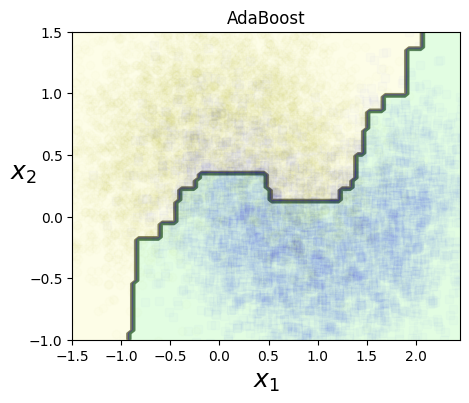

In [325]:
fig, axes = plt.subplots(ncols=1, figsize=(5,4), sharey=True)
plot_decision_boundary(ada_clf,X,y)
plt.title("AdaBoost")
plt.show()

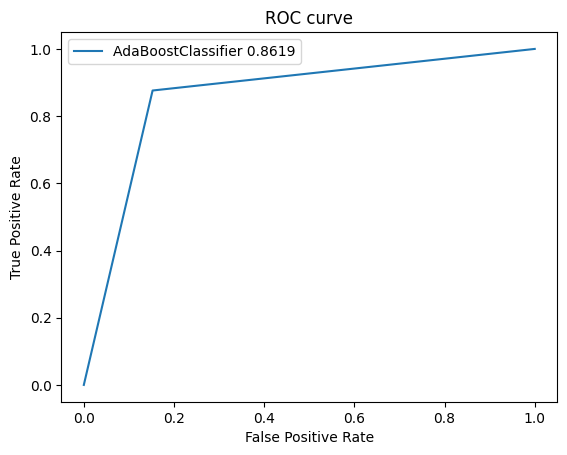

In [365]:
ROC(ada_clf)

### Gradient Boosting
fitting to the residual error made by the previous predictor

In [371]:
from sklearn.ensemble import GradientBoostingClassifier
###72 from the early stopping
grad_clf=GradientBoostingClassifier(max_depth=2, n_estimators=72, learning_rate=0.1, random_state=42)

In [372]:
%timeit grad_clf.fit(X_train,y_train)

269 ms ± 5.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


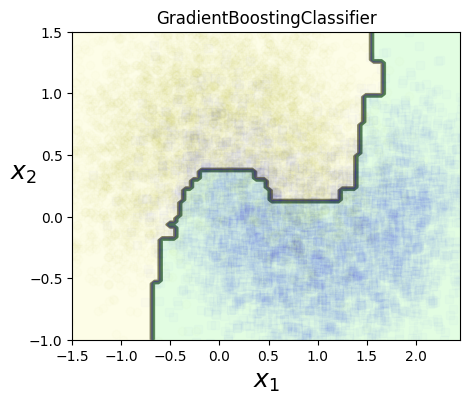

In [373]:
fig, axes = plt.subplots(ncols=1, figsize=(5,4), sharey=True)
plot_decision_boundary(grad_clf,X,y)
plt.title("GradientBoostingClassifier")
plt.show()

In [374]:
from sklearn.metrics import mean_squared_error
errors = [mean_squared_error(y_test, y_pred)
          for y_pred in grad_clf.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors) + 1

In [ ]:
plt.plot(np.linspace(1,len(errors),100), errors, label="MSE")
plt.title("MSE agaisnt number of trees")
plt.ylabel("MSE")
plt.xlabel("number of trees")
plt.axvline(72, 0, 0.8, color="orange", label="72 trees")
plt.legend()

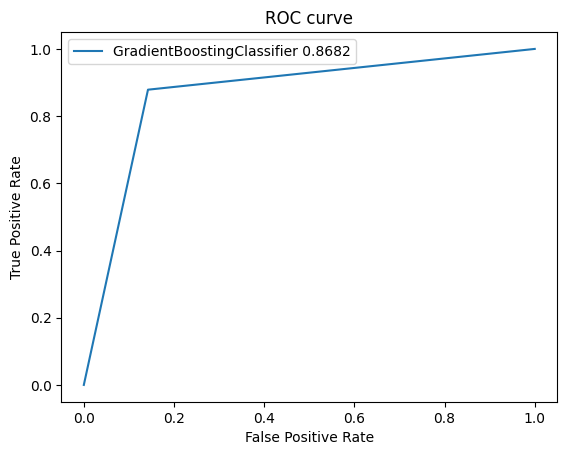

In [376]:
ROC(grad_clf)

In [370]:
grad_clf.predict([[2,1.5]])

array([1], dtype=int64)

### XGBoost

In [378]:
!pip install xgboost

     -------------------------------------- 125.4/125.4 MB 1.2 MB/s eta 0:00:00


In [387]:
import xgboost

xgb_clf=xgboost.XGBClassifier(max_depth=2, n_estimators=72, learning_rate=0.1, random_state=42)
%timeit xgb_clf.fit(X_train,y_train)

136 ms ± 769 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [388]:
y_pred=xgb_clf.predict(X_test)

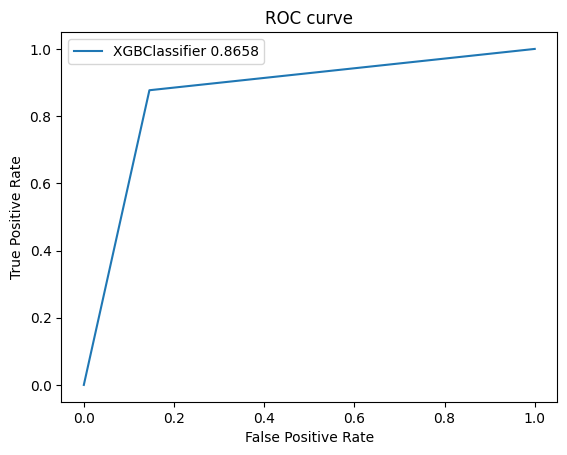

In [389]:
ROC(xgb_clf)

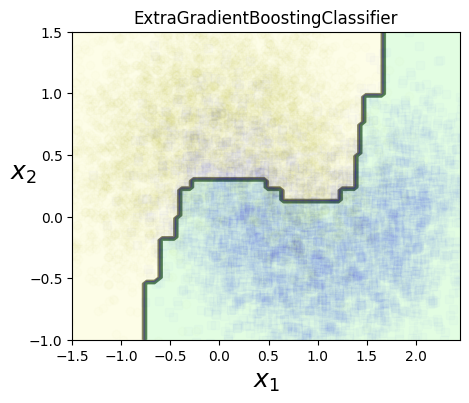

In [390]:
fig, axes = plt.subplots(ncols=1, figsize=(5,4), sharey=True)
plot_decision_boundary(xgb_clf,X,y)
plt.title("ExtraGradientBoostingClassifier")
plt.show()

## Exercices 8 and 9

### Voting Classifier ex. 8

#### load the dataset

In [392]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [394]:
mnist.data.shape

(70000, 784)

#### train,val, test split

In [395]:
X_train_val, X_test,y_train_val, y_test=train_test_split(mnist["data"],mnist["target"],test_size=10000, random_state=42)

In [396]:
X_train,X_val,y_train,y_val=train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

### build models

In [426]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
rand_clf=RandomForestClassifier(n_estimators=100, random_state=42)
extra_rand_clf=ExtraTreesClassifier(n_estimators=100, random_state=42)
svc_clf=LinearSVC(max_iter=100, tol=20, random_state=42)

In [427]:
for clf in [rand_clf, extra_rand_clf, svc_clf]:
    clf.fit(X_train,y_train)
    y_pred_val=clf.predict(X_val)
    print(clf.__class__.__name__)
    print("accuracy",accuracy_score(y_val,y_pred_val))
    print("recall",recall_score(y_val,y_pred_val, average='micro'))
    print("precision", precision_score(y_val,y_pred_val, average='micro'))

RandomForestClassifier
accuracy 0.9692
recall 0.9692
precision 0.9692
ExtraTreesClassifier
accuracy 0.9715
recall 0.9715
precision 0.9715
LinearSVC
accuracy 0.859
recall 0.859
precision 0.859


In [413]:
from sklearn.ensemble import VotingClassifier

voting_clf=VotingClassifier(
[
   ("Random",rand_clf),
    ("extra_rand",extra_rand_clf),
    ("svc_clf", svc_clf)
], voting="hard"
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('Random',
                              RandomForestClassifier(random_state=42)),
                             ('extra_rand',
                              ExtraTreesClassifier(random_state=42)),
                             ('svc_clf',
                              LinearSVC(max_iter=100, random_state=42,
                                        tol=20))])

In [414]:
voting_clf.score(X_val,y_val)

0.9693

In [415]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.859]

In [422]:
##test set:
voting_clf.score(X_test,y_test)

0.965

In [423]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.8566]

so, the LinearSVC may need more hyperparaemter tuning, but all in all, it is 97% acuracy. we may get to 97-98 by getting rid of LinearSVC


### Stacking Classifier 9

#### creating a new dataset 
(validation set), that the stacking model will be trained on

In [428]:
#shape has to be: 10000x3 
y_val_dataset=[]
for clf in [rand_clf, extra_rand_clf, svc_clf]:
    y_val_dataset.append(clf.predict(X_val))
y_val_dataset=np.array(y_val_dataset).transpose()

### training

In [439]:
rand_stack_clf=RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rand_stack_clf.fit(y_val_dataset,y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [440]:
rand_stack_clf.oob_score_

0.9703

### evaluating on the test set!


In [443]:
#shape has to be: 10000x3 
y_test_dataset=[]
for clf in [rand_clf, extra_rand_clf, svc_clf]:
    y_test_dataset.append(clf.predict(X_test))
y_test_dataset=np.array(y_test_dataset).transpose()

In [444]:
rand_stack_clf.score(y_test_dataset, y_test)

0.9661

better than the voting classifier! and 0.03 not as good as the ExtraRandom Forest, but still pretty good. a useful technique!